<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_11/%D0%94%D0%B5%D0%BC%D0%BE_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D1%83%D1%80_%D0%B2_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация текстур

Код ниже очень напоминает код из прошлого урока -- ведь по сути мы делаем все то же самое. Нужно только добавить сравнение матриц Грама в лосс и их вычисление.

In [1]:
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm

# tf.enable_eager_execution()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
#@title

def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [4]:
url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
image_path = tf.keras.utils.get_file('stones.jpg', url)

1875968/1866097 [==============================] - 0s 0us/step


(0.9996431, (1, 170, 256, 3))

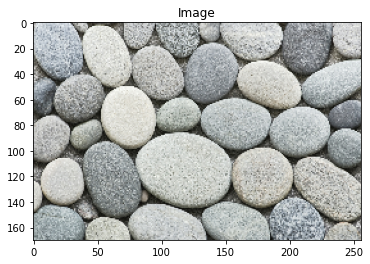

In [5]:
style_image = load_img(image_path, 256)
imshow(style_image, 'Image')
style_image.numpy().max(), style_image.numpy().shape # убедимся, что картинка нужного размера, а также значения 
                                                         # лежат в промежутке от 0 до 1

# Матрица Грама
Матрица Грама для слоя $l$ считается по формуле:
$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Здесь дословно написано: то, что получится в матрице в позиции $c, d$ равно сумме произведений активаций канала $c$ и $d$, деленное на количество таких активаций. 

Это можно записать с помощью функции ниже используя специальную нотацию.


In [6]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [7]:
class StyleExtractor:
  def __init__(self, layers):
    self.vgg_outputs_model =  get_vgg_layers_model(layers)
    self.vgg_outputs_model.trainable = False
    self.style_layers = layers
    
  def __call__(self, inputs):
    """
    На входе 4х мерный тензор (картинка). Значения пикселей ограничены 0..1!

    На выходе: {"имя слоя": матрица грамма выхода этого слоя}
    """
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG препроцессинг
    outputs = self.vgg_outputs_model(preprocessed_input)
    # посчитаем матрицу грамма для каждого выхода
    style_outputs = [gram_matrix(style_output)
                        for style_output in outputs]

    # добавим выходы в словарь, где ключ -- имя слоя, а значение -- его матрица грамма
    features_dict = {name:value for name, value in zip(self.style_layers, style_outputs)}

    return features_dict

In [8]:
# выберем эти слои для сравнения матриц
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

extractor = StyleExtractor(style_layers)
style_targets = extractor(style_image)
for k, v in style_targets.items():
    print(f"{k}:{v.numpy().shape}")

80150528/80134624 [==============================] - 0s 0us/step
block1_conv1:(1, 64, 64)
block2_conv1:(1, 128, 128)
block3_conv1:(1, 256, 256)
block4_conv1:(1, 512, 512)
block5_conv1:(1, 512, 512)


#  Определение лосса

Для вычисления лосса нам нужно знать с чем сравнивать матрицы грамма активаций сети для сгенерированного изображения.

Мы можем их вычислить один раз для оригинального изображения и затем сравнивать с ними.

In [9]:
# Переменная style_targets -- содержит словарь в котором сохранены матрицы грамма промежуточных выходов сети примененной к оригинальной картинке
extractor = StyleExtractor(style_layers)
style_targets = extractor(style_image)

Определим лосс:

In [10]:
def loss(image): 
    """
    Получаем картинку, вычисляем признаки с помощью класса StyleExtractor. 
    Сравниваем их с style_targets с помощью MeanSquaredError.
    """
    current_features = extractor(image)
    loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features[name], style_targets[name]) 
                                     for name in current_features.keys()])
    loss *= 1. / len(current_features)

    # для того чтобы результаты были больше похожи на настоящую картинку -- добавим регуляризацию
    # в реальных картинках цвета меняются плавно и нет цветового шума (шумные цветные пиксели поверх картинки)
    # при оптимизации мы часто будем получать такие результаты -- чтобы их уменьшать будуем штрафовать за такие резкие перепады цветов.
    # tota_variation -- нам в этом поможет
    loss += tf.image.total_variation(image)*1e4
    return loss

In [11]:
def train_step(image, loss_func, optimizer):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет
    нам полезна в дальнейшем.

    """
    
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    optimizer.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
                                         # картинка после этого шага изменилась!
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()

In [12]:
def show_pair(original, generated, title=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

# Собираем все вместе

1875968/1866097 [==============================] - 0s 0us/step


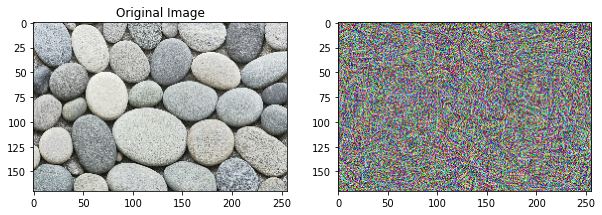

In [13]:
url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
#url = "https://cdn.britannica.com/s:500x350/86/170586-120-7E23E561.jpg"
image_path = tf.keras.utils.get_file('pebble.jpg', url)
style_image = load_img(image_path, 256)
style_targets = extractor(style_image)

image = tf.Variable(np.random.rand(*style_image.numpy().shape).astype(np.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)

# сделаем шаг оптимизации -- убедимся что все работает без ошибок.
train_step(image, loss_func=loss, optimizer=opt)
show_pair(style_image, image)

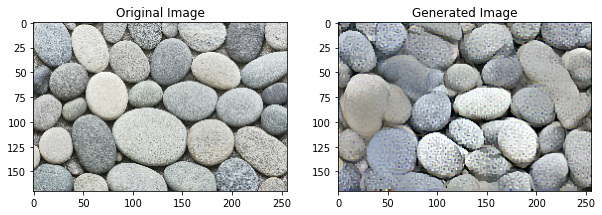

In [14]:
start = time.time()

epochs = 50
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(style_image, image, f"Generated Image.Train step: {step}")
  plt.savefig(f"result_{step:5d}.png", bbox_inches='tight')
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(style_image, image, f"Generated Image")
plt.savefig(f"result.png", bbox_inches='tight')

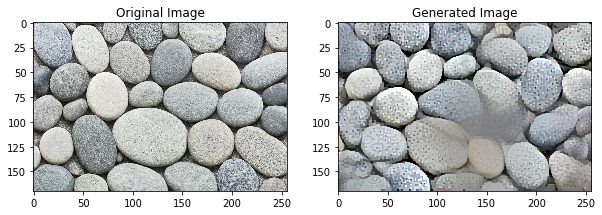

In [ ]:
start = time.time()

epochs = 50
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(style_image, image, f"Generated Image.Train step: {step}")
  plt.savefig(f"result_{step:5d}.png", bbox_inches='tight')
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(style_image, image, f"Generated Image")
plt.savefig(f"result.png", bbox_inches='tight')

In [ ]:
import imageio
from pathlib import Path
filenames = sorted(list(Path(".").glob("result_*")))
print(filenames)
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration=0.1)


[PosixPath('result_   10.png'), PosixPath('result_   20.png'), PosixPath('result_   30.png'), PosixPath('result_   40.png'), PosixPath('result_   50.png'), PosixPath('result_   60.png'), PosixPath('result_   70.png'), PosixPath('result_   80.png'), PosixPath('result_   90.png'), PosixPath('result_  100.png'), PosixPath('result_  110.png'), PosixPath('result_  120.png'), PosixPath('result_  130.png'), PosixPath('result_  140.png'), PosixPath('result_  150.png'), PosixPath('result_  160.png'), PosixPath('result_  170.png'), PosixPath('result_  180.png'), PosixPath('result_  190.png'), PosixPath('result_  200.png'), PosixPath('result_  210.png'), PosixPath('result_  220.png'), PosixPath('result_  230.png'), PosixPath('result_  240.png'), PosixPath('result_  250.png'), PosixPath('result_  260.png'), PosixPath('result_  270.png'), PosixPath('result_  280.png'), PosixPath('result_  290.png'), PosixPath('result_  300.png'), PosixPath('result_  310.png'), PosixPath('result_  320.png'), PosixPa

# Заключение

Мои поздравления. Мы научились генерировать текстуры! Решение поставленной нами задачи оказалось очень находчивым. Можно только удивляться как авторы статьи придумали такой подход к решению. Но еще более ошеломительные результаты показала следующая статья этих же авторов -- статья про перенос стиля. Как же они это сделали? Об этом мы узнаем в следующем уроке. 

А сейчас предлагаю вам попрактиковаться -- выбрать 2-3 текстуры и попробовать сгенерировать новые из них. Для улучшения результата, попробуйте изменять параметры оптимизатора, степень регуляризации и тд.



## Практика

Выберите 2-3 текстуры и сгенерируйте из них новые. Попробуйте улучшить качество с помощью изменения параметров

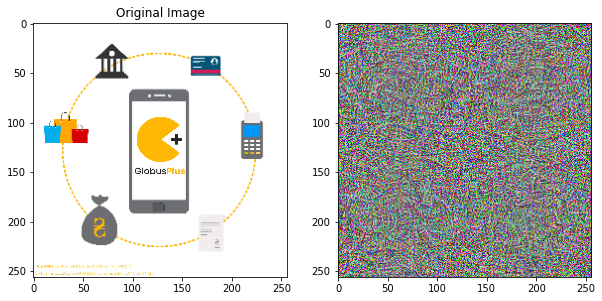

In [21]:
#url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
#url = "https://cdn.britannica.com/s:500x350/86/170586-120-7E23E561.jpg"
#image_path = tf.keras.utils.get_file('pebble.jpg', url)
style_image = load_img('gp_1.png', 256)
style_targets = extractor(style_image)

image = tf.Variable(np.random.rand(*style_image.numpy().shape).astype(np.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)

# сделаем шаг оптимизации -- убедимся что все работает без ошибок.
train_step(image, loss_func=loss, optimizer=opt)
show_pair(style_image, image)

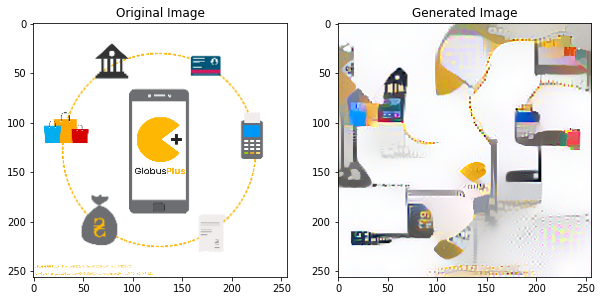

In [22]:
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(style_image, image, f"Generated Image.Train step: {step}")
  plt.savefig(f"result_{step:5d}.png", bbox_inches='tight')
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(style_image, image, f"Generated Image")
plt.savefig(f"result.png", bbox_inches='tight')